In [1]:
import chenxicrypto as cc # version 1.2.1
import torch
import time

In [2]:
class PNN(torch.nn.Module):
    def __init__(self):
        super(PNN, self).__init__()
        self.layer1 = torch.nn.Linear(3, 128)
        self.layer2 = torch.nn.Linear(128, 1024)
        self.layer3 = torch.nn.Linear(1024, 256)
        self.layer4 = torch.nn.Linear(256, 64)
        self.layer5 = torch.nn.Linear(64, 16)
        self.layer6 = torch.nn.Linear(16, 4)
        self.layer7 = torch.nn.Linear(4, 1)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.relu(self.layer6(x))
        x = self.sigmoid(self.layer7(x))
        return x
    
pnn = PNN()

class Simul(cc.Simulation):
    def __init__(self):
        super(Simul, self).__init__()
        self.symbol = 'BTC-USDT'
        self.ttype = '1min'
        self.ln_p_all = None
        
    def forward(self):
        X = torch.Tensor([(self.MA5[self.i] - self.priceList[self.i]) / self.priceList[self.i], 
                          (self.MA10[self.i] - self.priceList[self.i]) / self.priceList[self.i],
                          (self.MA30[self.i] - self.priceList[self.i]) / self.priceList[self.i]])
        self.p = pnn(X)
    
    def beforeStep(self):
        self.forward()
    
    def buySignal(self):
        buyPercent = 0.0
        if self.p.data > 0.5:
            buyPercent = (self.p.data - 0.5) * 2
            buyPercent = buyPercent.item()
        return buyPercent

    def sellSignal(self):
        sellPercent = 0.0
        if self.p.data < 0.5:
            sellPercent = (0.5 - self.p.data) * 2
            sellPercent = sellPercent.item()
        return sellPercent
    
    def afterStep(self):
        if self.ln_p_all == None:
            if self.p.data > 0.5:
                self.ln_p_all = torch.log(self.p)
            else:
                self.ln_p_all = - torch.log(self.p)
        else:
            if self.p.data > 0.5:
                self.ln_p_all += torch.log(self.p)
            else:
                self.ln_p_all -= torch.log(self.p)
    
simul = Simul()

In [3]:
optimizer = torch.optim.SGD(pnn.parameters(), lr = 0.1)

# prepare data
startAt_all = '2022-01-01 00:00:00'
endAt_all = '2022-01-01 23:59:59'
ttype = '1min'
symbol = 'BTC-USDT'

data = cc.FetchData()
timeList_all = data.timeStamp(startAt_all, endAt_all, ttype)
priceList_all = data.close(symbol, startAt_all, endAt_all, ttype)
MA5_all = data.MA(symbol, startAt_all, endAt_all, ttype, 'close', 5)
MA10_all = data.MA(symbol, startAt_all, endAt_all, ttype, 'close', 10)
MA30_all = data.MA(symbol, startAt_all, endAt_all, ttype, 'close', 30)
print('data ready', len(timeList_all), len(priceList_all) ,len(MA5_all))

# replicate
for epoch in range(100):
    print('epoch', epoch)
    rp_sum = 0
    for hour in range(24):
        # within an hour
        simul.startAt = None
        simul.endAt = None
        simul.timeList = timeList_all[hour*60:(hour+1)*60]
        simul.priceList = priceList_all[hour*60:(hour+1)*60]
        simul.MA5 = MA5_all[hour*60:(hour+1)*60]
        simul.MA10 = MA10_all[hour*60:(hour+1)*60]
        simul.MA30 = MA30_all[hour*60:(hour+1)*60]

        # simulate for each hour, 60 steps (each min)
        simul.ln_p_all = None
        simul.simulate()
        relative_profit = simul.profit - simul.simpleProfit
        rp_sum += relative_profit
        loss = - relative_profit * simul.ln_p_all
        print('hour profit =', '%.8f'%simul.profit, ' relative profit =', '%.8f'%relative_profit)

        # upgrade once an hour
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch average relative profit = ', rp_sum/24)
    
fname = time.strftime("%Y%m%d_%H%M%S", time.localtime(time.time())) + '.pkl'
torch.save(pnn, fname)
print('model saved')

data ready 1440 1440 1440
epoch 0
hour profit = -0.01051577  relative profit = -0.00042346
hour profit = -0.00952137  relative profit = 0.00130280
hour profit = -0.00675544  relative profit = 0.00046853
hour profit = -0.01891278  relative profit = 0.00089939
hour profit = -0.00267272  relative profit = -0.00076713
hour profit = 0.00879793  relative profit = -0.00048795
hour profit = -0.00187009  relative profit = -0.00097918
hour profit = -0.00414532  relative profit = -0.00029148
hour profit = 0.00683450  relative profit = -0.00085126
hour profit = 0.00325752  relative profit = -0.00071932
hour profit = -0.00036858  relative profit = -0.00045405
hour profit = 0.00049019  relative profit = 0.00006711
hour profit = -0.00276992  relative profit = 0.00009701
hour profit = 0.01014670  relative profit = 0.00022999
hour profit = -0.00424301  relative profit = -0.00033551
hour profit = 0.00427759  relative profit = -0.00094485
hour profit = -0.00072363  relative profit = -0.00032898
hour prof

hour profit = -0.00165716  relative profit = 0.00101960
hour profit = -0.00200895  relative profit = 0.00033400
hour profit = 0.00565706  relative profit = -0.00096893
epoch average relative profit =  -0.00025201534405159187
epoch 6
hour profit = -0.01060969  relative profit = -0.00051738
hour profit = -0.00884683  relative profit = 0.00197734
hour profit = -0.00664084  relative profit = 0.00058313
hour profit = -0.01833119  relative profit = 0.00148098
hour profit = -0.00307877  relative profit = -0.00117319
hour profit = 0.00886948  relative profit = -0.00041640
hour profit = -0.00207369  relative profit = -0.00118277
hour profit = -0.00422451  relative profit = -0.00037066
hour profit = 0.00665376  relative profit = -0.00103200
hour profit = 0.00287207  relative profit = -0.00110477
hour profit = -0.00049134  relative profit = -0.00057681
hour profit = 0.00038128  relative profit = -0.00004179
hour profit = -0.00249128  relative profit = 0.00037566
hour profit = 0.00976790  relative

hour profit = -0.00109001  relative profit = -0.00069536
hour profit = 0.00020275  relative profit = -0.00149487
hour profit = -0.00576781  relative profit = 0.00182333
hour profit = -0.00323284  relative profit = -0.00094567
hour profit = 0.00400228  relative profit = -0.00169770
hour profit = -0.00148944  relative profit = 0.00118733
hour profit = -0.00193361  relative profit = 0.00040934
hour profit = 0.00503527  relative profit = -0.00159072
epoch average relative profit =  -0.00028119886291968024
epoch 12
hour profit = -0.01069091  relative profit = -0.00059859
hour profit = -0.00702111  relative profit = 0.00380307
hour profit = -0.00629307  relative profit = 0.00093090
hour profit = -0.01674184  relative profit = 0.00307033
hour profit = -0.00334645  relative profit = -0.00144086
hour profit = 0.00864179  relative profit = -0.00064408
hour profit = -0.00226568  relative profit = -0.00137476
hour profit = -0.00427723  relative profit = -0.00042338
hour profit = 0.00630105  relati

hour profit = -0.00107426  relative profit = 0.00179267
hour profit = 0.00530082  relative profit = -0.00461589
hour profit = -0.00386502  relative profit = 0.00004249
hour profit = 0.00351039  relative profit = -0.00171206
hour profit = -0.00135102  relative profit = -0.00095637
hour profit = 0.00054787  relative profit = -0.00114974
hour profit = -0.00322776  relative profit = 0.00436338
hour profit = -0.00301741  relative profit = -0.00073023
hour profit = 0.00265608  relative profit = -0.00304389
hour profit = -0.00098516  relative profit = 0.00169161
hour profit = -0.00149718  relative profit = 0.00084577
hour profit = 0.00327023  relative profit = -0.00335576
epoch average relative profit =  -8.053108105929777e-05
epoch 18
hour profit = -0.00844306  relative profit = 0.00164925
hour profit = -0.00390495  relative profit = 0.00691922
hour profit = -0.00534878  relative profit = 0.00187519
hour profit = -0.01411987  relative profit = 0.00569230
hour profit = -0.00320460  relative p

hour profit = -0.00407810  relative profit = -0.00022426
hour profit = 0.00552623  relative profit = -0.00215953
hour profit = 0.00110007  relative profit = -0.00287677
hour profit = -0.00058322  relative profit = -0.00066869
hour profit = -0.00007933  relative profit = -0.00050240
hour profit = -0.00101005  relative profit = 0.00185689
hour profit = 0.00500100  relative profit = -0.00491572
hour profit = -0.00371617  relative profit = 0.00019133
hour profit = 0.00338235  relative profit = -0.00184010
hour profit = -0.00132132  relative profit = -0.00092667
hour profit = 0.00056596  relative profit = -0.00113165
hour profit = -0.00294992  relative profit = 0.00464122
hour profit = -0.00295173  relative profit = -0.00066456
hour profit = 0.00252749  relative profit = -0.00317249
hour profit = -0.00092207  relative profit = 0.00175470
hour profit = -0.00143270  relative profit = 0.00091025
hour profit = 0.00309043  relative profit = -0.00353556
epoch average relative profit =  -1.2492172

hour profit = -0.01393296  relative profit = 0.00587921
hour profit = -0.00318918  relative profit = -0.00128359
hour profit = 0.00773694  relative profit = -0.00154894
hour profit = -0.00214775  relative profit = -0.00125683
hour profit = -0.00407690  relative profit = -0.00022305
hour profit = 0.00552316  relative profit = -0.00216261
hour profit = 0.00109816  relative profit = -0.00287868
hour profit = -0.00058288  relative profit = -0.00066835
hour profit = -0.00007961  relative profit = -0.00050269
hour profit = -0.00100895  relative profit = 0.00185798
hour profit = 0.00499462  relative profit = -0.00492209
hour profit = -0.00371416  relative profit = 0.00019334
hour profit = 0.00338060  relative profit = -0.00184185
hour profit = -0.00132096  relative profit = -0.00092631
hour profit = 0.00056607  relative profit = -0.00113154
hour profit = -0.00294832  relative profit = 0.00464283
hour profit = -0.00295058  relative profit = -0.00066340
hour profit = 0.00252557  relative profit

hour profit = 0.00308684  relative profit = -0.00353915
epoch average relative profit =  -1.1796854826800859e-05
epoch 35
hour profit = -0.00799002  relative profit = 0.00210229
hour profit = -0.00368581  relative profit = 0.00713837
hour profit = -0.00526236  relative profit = 0.00196161
hour profit = -0.01392589  relative profit = 0.00588627
hour profit = -0.00318820  relative profit = -0.00128262
hour profit = 0.00773358  relative profit = -0.00155229
hour profit = -0.00214707  relative profit = -0.00125615
hour profit = -0.00407599  relative profit = -0.00022215
hour profit = 0.00552085  relative profit = -0.00216491
hour profit = 0.00109681  relative profit = -0.00288002
hour profit = -0.00058266  relative profit = -0.00066813
hour profit = -0.00007978  relative profit = -0.00050286
hour profit = -0.00100832  relative profit = 0.00185861
hour profit = 0.00499047  relative profit = -0.00492624
hour profit = -0.00371332  relative profit = 0.00019418
hour profit = 0.00337984  relativ

hour profit = -0.00294918  relative profit = 0.00464196
hour profit = -0.00294941  relative profit = -0.00066223
hour profit = 0.00252381  relative profit = -0.00317617
hour profit = -0.00092148  relative profit = 0.00175529
hour profit = -0.00143133  relative profit = 0.00091162
hour profit = 0.00308562  relative profit = -0.00354037
epoch average relative profit =  -1.1747654599664868e-05
epoch 41
hour profit = -0.00799031  relative profit = 0.00210201
hour profit = -0.00368459  relative profit = 0.00713958
hour profit = -0.00525977  relative profit = 0.00196420
hour profit = -0.01391892  relative profit = 0.00589325
hour profit = -0.00318723  relative profit = -0.00128165
hour profit = 0.00773026  relative profit = -0.00155562
hour profit = -0.00214639  relative profit = -0.00125547
hour profit = -0.00407510  relative profit = -0.00022125
hour profit = 0.00551858  relative profit = -0.00216718
hour profit = 0.00109549  relative profit = -0.00288135
hour profit = -0.00058245  relativ

hour profit = 0.00498302  relative profit = -0.00493369
hour profit = -0.00371183  relative profit = 0.00019568
hour profit = 0.00337848  relative profit = -0.00184396
hour profit = -0.00132073  relative profit = -0.00092608
hour profit = 0.00056609  relative profit = -0.00113152
hour profit = -0.00294967  relative profit = 0.00464148
hour profit = -0.00294878  relative profit = -0.00066161
hour profit = 0.00252286  relative profit = -0.00317711
hour profit = -0.00092144  relative profit = 0.00175533
hour profit = -0.00143103  relative profit = 0.00091193
hour profit = 0.00308442  relative profit = -0.00354157
epoch average relative profit =  -1.1698986126887288e-05
epoch 47
hour profit = -0.00799058  relative profit = 0.00210173
hour profit = -0.00368340  relative profit = 0.00714077
hour profit = -0.00525721  relative profit = 0.00196676
hour profit = -0.01391202  relative profit = 0.00590015
hour profit = -0.00318628  relative profit = -0.00128069
hour profit = 0.00772697  relative 

hour profit = 0.00551447  relative profit = -0.00217129
hour profit = 0.00109309  relative profit = -0.00288374
hour profit = -0.00058207  relative profit = -0.00066754
hour profit = -0.00008025  relative profit = -0.00050333
hour profit = -0.00100659  relative profit = 0.00186034
hour profit = 0.00497901  relative profit = -0.00493770
hour profit = -0.00371102  relative profit = 0.00019648
hour profit = 0.00337775  relative profit = -0.00184469
hour profit = -0.00132065  relative profit = -0.00092601
hour profit = 0.00056610  relative profit = -0.00113152
hour profit = -0.00295014  relative profit = 0.00464100
hour profit = -0.00294816  relative profit = -0.00066099
hour profit = 0.00252193  relative profit = -0.00317805
hour profit = -0.00092140  relative profit = 0.00175536
hour profit = -0.00143073  relative profit = 0.00091223
hour profit = 0.00308322  relative profit = -0.00354277
epoch average relative profit =  -1.1651159773315437e-05
epoch 53
hour profit = -0.00799086  relativ

hour profit = -0.01389952  relative profit = 0.00591264
hour profit = -0.00318454  relative profit = -0.00127895
hour profit = 0.00772101  relative profit = -0.00156486
hour profit = -0.00214450  relative profit = -0.00125359
hour profit = -0.00407260  relative profit = -0.00021875
hour profit = 0.00551225  relative profit = -0.00217352
hour profit = 0.00109180  relative profit = -0.00288503
hour profit = -0.00058186  relative profit = -0.00066733
hour profit = -0.00008041  relative profit = -0.00050349
hour profit = -0.00100599  relative profit = 0.00186094
hour profit = 0.00497504  relative profit = -0.00494168
hour profit = -0.00371023  relative profit = 0.00019727
hour profit = 0.00337703  relative profit = -0.00184541
hour profit = -0.00132058  relative profit = -0.00092593
hour profit = 0.00056610  relative profit = -0.00113151
hour profit = -0.00295060  relative profit = 0.00464054
hour profit = -0.00294755  relative profit = -0.00066038
hour profit = 0.00252101  relative profit

epoch average relative profit =  -1.1563728579337855e-05
epoch 64
hour profit = -0.00799138  relative profit = 0.00210094
hour profit = -0.00368008  relative profit = 0.00714409
hour profit = -0.00525009  relative profit = 0.00197388
hour profit = -0.01389280  relative profit = 0.00591936
hour profit = -0.00318360  relative profit = -0.00127801
hour profit = 0.00771780  relative profit = -0.00156808
hour profit = -0.00214384  relative profit = -0.00125293
hour profit = -0.00407173  relative profit = -0.00021788
hour profit = 0.00551005  relative profit = -0.00217571
hour profit = 0.00109053  relative profit = -0.00288631
hour profit = -0.00058166  relative profit = -0.00066713
hour profit = -0.00008057  relative profit = -0.00050365
hour profit = -0.00100540  relative profit = 0.00186153
hour profit = 0.00497111  relative profit = -0.00494560
hour profit = -0.00370944  relative profit = 0.00019806
hour profit = 0.00337632  relative profit = -0.00184612
hour profit = -0.00132050  relati

hour profit = 0.00251935  relative profit = -0.00318063
hour profit = -0.00092130  relative profit = 0.00175547
hour profit = -0.00142989  relative profit = 0.00091306
hour profit = 0.00307993  relative profit = -0.00354606
epoch average relative profit =  -1.151610893894298e-05
epoch 70
hour profit = -0.00799165  relative profit = 0.00210066
hour profit = -0.00367894  relative profit = 0.00714523
hour profit = -0.00524763  relative profit = 0.00197634
hour profit = -0.01388617  relative profit = 0.00592600
hour profit = -0.00318267  relative profit = -0.00127708
hour profit = 0.00771462  relative profit = -0.00157126
hour profit = -0.00214319  relative profit = -0.00125228
hour profit = -0.00407086  relative profit = -0.00021702
hour profit = 0.00550787  relative profit = -0.00217789
hour profit = 0.00108928  relative profit = -0.00288756
hour profit = -0.00058146  relative profit = -0.00066693
hour profit = -0.00008073  relative profit = -0.00050381
hour profit = -0.00100481  relativ

hour profit = 0.00337503  relative profit = -0.00184741
hour profit = -0.00132036  relative profit = -0.00092571
hour profit = 0.00056612  relative profit = -0.00113149
hour profit = -0.00295189  relative profit = 0.00463925
hour profit = -0.00294585  relative profit = -0.00065868
hour profit = 0.00251845  relative profit = -0.00318152
hour profit = -0.00092127  relative profit = 0.00175550
hour profit = -0.00142961  relative profit = 0.00091334
hour profit = 0.00307879  relative profit = -0.00354720
epoch average relative profit =  -1.1469756943539324e-05
epoch 76
hour profit = -0.00799193  relative profit = 0.00210038
hour profit = -0.00367781  relative profit = 0.00714636
hour profit = -0.00524519  relative profit = 0.00197878
hour profit = -0.01387958  relative profit = 0.00593259
hour profit = -0.00318174  relative profit = -0.00127616
hour profit = 0.00771146  relative profit = -0.00157442
hour profit = -0.00214254  relative profit = -0.00125163
hour profit = -0.00407001  relativ

hour profit = -0.00008102  relative profit = -0.00050409
hour profit = -0.00100376  relative profit = 0.00186318
hour profit = 0.00496023  relative profit = -0.00495648
hour profit = -0.00370726  relative profit = 0.00020024
hour profit = 0.00337434  relative profit = -0.00184811
hour profit = -0.00132029  relative profit = -0.00092564
hour profit = 0.00056613  relative profit = -0.00113149
hour profit = -0.00295233  relative profit = 0.00463881
hour profit = -0.00294526  relative profit = -0.00065809
hour profit = 0.00251757  relative profit = -0.00318241
hour profit = -0.00092123  relative profit = 0.00175554
hour profit = -0.00142933  relative profit = 0.00091363
hour profit = 0.00307766  relative profit = -0.00354832
epoch average relative profit =  -1.14235942455884e-05
epoch 82
hour profit = -0.00799221  relative profit = 0.00210010
hour profit = -0.00367670  relative profit = 0.00714748
hour profit = -0.00524277  relative profit = 0.00198120
hour profit = -0.01387306  relative p

hour profit = -0.00214137  relative profit = -0.00125045
hour profit = -0.00406845  relative profit = -0.00021460
hour profit = 0.00550180  relative profit = -0.00218396
hour profit = 0.00108578  relative profit = -0.00289106
hour profit = -0.00058089  relative profit = -0.00066637
hour profit = -0.00008117  relative profit = -0.00050424
hour profit = -0.00100319  relative profit = 0.00186374
hour profit = 0.00495645  relative profit = -0.00496026
hour profit = -0.00370650  relative profit = 0.00020100
hour profit = 0.00337365  relative profit = -0.00184879
hour profit = -0.00132021  relative profit = -0.00092556
hour profit = 0.00056613  relative profit = -0.00113148
hour profit = -0.00295277  relative profit = 0.00463837
hour profit = -0.00294468  relative profit = -0.00065750
hour profit = 0.00251670  relative profit = -0.00318328
hour profit = -0.00092120  relative profit = 0.00175557
hour profit = -0.00142905  relative profit = 0.00091391
hour profit = 0.00307655  relative profit 

hour profit = -0.00523840  relative profit = 0.00198557
hour profit = -0.01386125  relative profit = 0.00595092
hour profit = -0.00317916  relative profit = -0.00127357
hour profit = 0.00770265  relative profit = -0.00158322
hour profit = -0.00214074  relative profit = -0.00124982
hour profit = -0.00406761  relative profit = -0.00021376
hour profit = 0.00549969  relative profit = -0.00218607
hour profit = 0.00108457  relative profit = -0.00289227
hour profit = -0.00058070  relative profit = -0.00066617
hour profit = -0.00008132  relative profit = -0.00050440
hour profit = -0.00100262  relative profit = 0.00186431
hour profit = 0.00495272  relative profit = -0.00496399
hour profit = -0.00370576  relative profit = 0.00020174
hour profit = 0.00337297  relative profit = -0.00184947
hour profit = -0.00132014  relative profit = -0.00092549
hour profit = 0.00056614  relative profit = -0.00113147
hour profit = -0.00295320  relative profit = 0.00463794
hour profit = -0.00294410  relative profit

hour profit = -0.00142854  relative profit = 0.00091441
hour profit = 0.00307454  relative profit = -0.00355144
epoch average relative profit =  -1.1294097849723802e-05
epoch 99
hour profit = -0.00799298  relative profit = 0.00209933
hour profit = -0.00367362  relative profit = 0.00715055
hour profit = -0.00523605  relative profit = 0.00198792
hour profit = -0.01385490  relative profit = 0.00595727
hour profit = -0.00317826  relative profit = -0.00127267
hour profit = 0.00769959  relative profit = -0.00158628
hour profit = -0.00214011  relative profit = -0.00124919
hour profit = -0.00406678  relative profit = -0.00021293
hour profit = 0.00549760  relative profit = -0.00218816
hour profit = 0.00108338  relative profit = -0.00289346
hour profit = -0.00058050  relative profit = -0.00066598
hour profit = -0.00008147  relative profit = -0.00050455
hour profit = -0.00100207  relative profit = 0.00186487
hour profit = 0.00494902  relative profit = -0.00496769
hour profit = -0.00370502  relati

day profit = -0.01175801  relative profit = 0.00367864


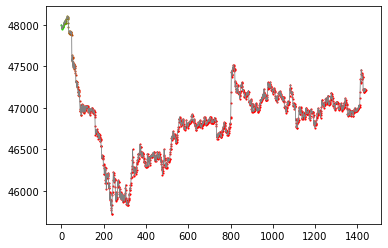

In [7]:
# visualize
class Test(cc.Simulation):
    def __init__(self):
        super(Test, self).__init__()
        self.symbol = 'BTC-USDT'
        self.ttype = '1min'
        self.startAt = '2022-01-01 00:00:00'
        self.endAt = '2022-01-01 23:59:59'
        self.MA5 = data.MA(self.symbol, self.startAt, self.endAt, self.ttype, 'close', 5)
        self.MA10 = data.MA(self.symbol, self.startAt, self.endAt, self.ttype, 'close', 10)
        self.MA30 = data.MA(self.symbol, self.startAt, self.endAt, self.ttype, 'close', 30)
        
    def forward(self):
        with torch.no_grad():
            X = torch.Tensor([(self.MA5[self.i] - self.priceList[self.i]) / self.priceList[self.i], 
                              (self.MA10[self.i] - self.priceList[self.i]) / self.priceList[self.i],
                              (self.MA30[self.i] - self.priceList[self.i]) / self.priceList[self.i]])
            self.p = pnn(X)
    
    def beforeStep(self):
        self.forward()
    
    def buySignal(self):
        buyPercent = 0.0
        if self.p.data > 0.5:
            buyPercent = (self.p.data - 0.5) * 2
            buyPercent = buyPercent.item()
        return buyPercent

    def sellSignal(self):
        sellPercent = 0.0
        if self.p.data < 0.5:
            sellPercent = (0.5 - self.p.data) * 2
            sellPercent = sellPercent.item()
        return sellPercent

test = Test()
test.simulate()
relative_profit = test.profit - test.simpleProfit
print('day profit =', '%.8f'%test.profit, ' relative profit =', '%.8f'%relative_profit)
test.visual()